Install Packages

In [67]:
import sys
import pandas as pd
import random
random.seed(10)
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, precision_recall_curve


Download the dataset from Kaggle and load 

In [47]:
fake_csv = pd.read_csv(".\dataset\Fake.csv")
true_csv = pd.read_csv(".\dataset\True.csv")

In [48]:
fake_csv.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [49]:
true_csv.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


Data Preprocessing


Add label 

In [ ]:
fake_csv['label'] = 1
true_csv['label'] = 0



(23481, 2)

Merge title and text, and drop title, text, subject, date column

In [ ]:
fake_csv['title+text'] = fake_csv['title'] + ' ' + fake_csv['text']
fake_csv = fake_csv.drop(columns=['title', 'text', 'subject', 'date'], axis=0)
fake_csv.shape

In [ ]:
true_csv['title+text'] = true_csv['title'] + ' ' + true_csv['text']
true_csv = true_csv.drop(columns=['title', 'text', 'subject', 'date'], axis=0)
true_csv.shape

(21417, 2)

Sampling equal numbers data from face_csv and true_csv

In [52]:
idx = [random.randrange(true_csv.shape[0]) for _ in range(1000)]
fake_csv_resampled = fake_csv.iloc[idx]
true_csv_resampled = true_csv.iloc[idx]

Text Preprocessing

Remove stop words and Lemmetization using spaCy

In [53]:
# nlp = English() # Load English tokenizer, tagger, parser, NER and word vectors
nlp = en_core_web_sm.load()
fake_csv_resampled['title+text'].apply(nlp)
true_csv_resampled['title+text'].apply(nlp)
fc = fake_csv_resampled.copy()
tc = true_csv_resampled.copy()


In [56]:
fc['filtered_words'] = fc['title+text'].apply(lambda vocabs: [vocab.lemma_ for vocab in nlp(vocabs) if not vocab.is_stop])
tc['filtered_words'] = tc['title+text'].apply(lambda vocabs: [vocab.lemma_ for vocab in nlp(vocabs) if not vocab.is_stop])
fc['filtered_words']

18723    [TRUMP, DELIVERS, BARN, BURNER, speech, :, ", ...
1067     [ , come, Cory, Booker, Pals, ', Field, trip, ...
14053    [obama, BRITAIN, Legacy, :, save, World, Econo...
15812    [[, video, ], watch, marco, rubio, Handles, re...
18942    [disturb, :, Tomi, Lahren, Panders, ", View, "...
                               ...                        
37       [ , Donald, Trump, Eating, habit, dramatically...
12230    [JILL, STEIN, Claims, Recount, possible, Forei...
8251     [ , state, let, gun, right, People, think, thi...
19081    [MAJOR, COSMETIC, Company, announce, plan, rel...
19067    [illegal, alien, protester, yell, Police, shut...
Name: filtered_words, Length: 1000, dtype: object

Removing Non-alphanumeric characters

In [57]:
fc['cleaned_lemmas'] = fc['filtered_words'].apply(lambda word_list:[word for word in word_list if word.isalpha()])
tc['cleaned_lemmas'] = tc['filtered_words'].apply(lambda word_list:[word for word in word_list if word.isalpha()])
tc['cleaned_lemmas']

18723    [migrant, smuggling, crackdown, trigger, clash...
1067     [Schumer, cite, untruth, Trump, Republicans, t...
14053    [urge, Australia, protect, refugee, Papua, New...
15812    [Russia, tell, unacceptable, politicize, chemi...
18942    [thai, PM, Yingluck, get, year, jail, term, ne...
                               ...                        
37       [factbox, big, ticket, item, center, Congress,...
12230    [Russia, Egypt, talk, resumption, date, russia...
8251     [invoke, religion, disciplined, Trump, speak, ...
19081    [alliance, say, russian, jet, strike, fighter,...
19067    [turnout, high, iraqi, Kurds, defy, threat, ho...
Name: cleaned_lemmas, Length: 1000, dtype: object

Combining the final lemmetized and cleaned list of words into sentences

In [58]:
df = pd.concat([fc,tc], axis=0)
df['text'] = df['cleaned_lemmas'].str.join(' ')
df = df.drop(columns=['title+text', 'filtered_words', 'cleaned_lemmas'])
df.head()

,label,text
18723,1,TRUMP DELIVERS BARN BURNER speech media outlet...
1067,1,come Cory Booker Pals Field trip find Super Se...
14053,1,obama BRITAIN Legacy save World Economy Deal I...
15812,1,video watch marco rubio Handles reporter Attem...
18942,1,disturb Tomi Lahren Panders View Hags say Pro ...


Feature Selection and split the data into test-train sets

In [ ]:
X = df['text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

Pipeine with TfidVectorizer and selection of Model

In [61]:
classifier = Pipeline([
    ("vectorizer_tfidf", TfidfVectorizer()),
    ("random_forest", RandomForestClassifier(n_jobs=-1, random_state=42))
])
classifier.fit(X_train,y_train)


Pipeline(steps=[('vectorizer_tfidf', TfidfVectorizer()),
                ('random_forest',
                 RandomForestClassifier(n_jobs=-1, random_state=42))])

In [62]:
accuracy = classifier.score(X_test, y_test) * 100
accuracy

98.5

In [63]:
pred = classifier.predict(X_test)
classification_report(y_test, pred)

'              precision    recall  f1-score   support\n\n           0       0.98      1.00      0.99       201\n           1       0.99      0.97      0.98       199\n\n    accuracy                           0.98       400\n   macro avg       0.99      0.98      0.98       400\nweighted avg       0.99      0.98      0.98       400\n'

In [66]:
recall = recall_score(y_test, pred)
recall

0.9748743718592965

In [71]:
precision, recall,_ = precision_recall_curve(y_test, pred)


Text(0.5, 1.0, 'Precision-Recall curve')

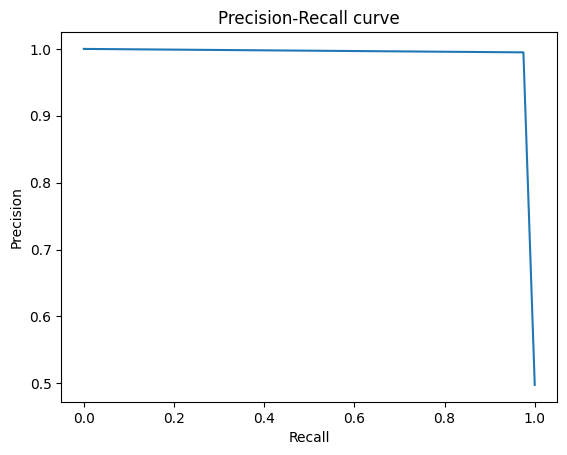

In [75]:
import matplotlib.pyplot as plt
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curve")